In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
from tqdm.notebook import tqdm
import os
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
sr = 16000

In [2]:
dropout = 0.3
half = False
device = 2
torch.cuda.set_device(device)

## EDA

Unnamed: 0                                               307461
anchor_speaker                                     valerie_voss
anchor_file          trainfiles/end_segments/ed980122_seg19.npy
positive_file        trainfiles/end_segments/d960604a_seg88.npy
negative_speaker                               ee970701_spkr_19
negative_file       trainfiles/end_segments/ee970701_seg135.npy
Name: 307461, dtype: object
0.10323380943892109
(128, 597)


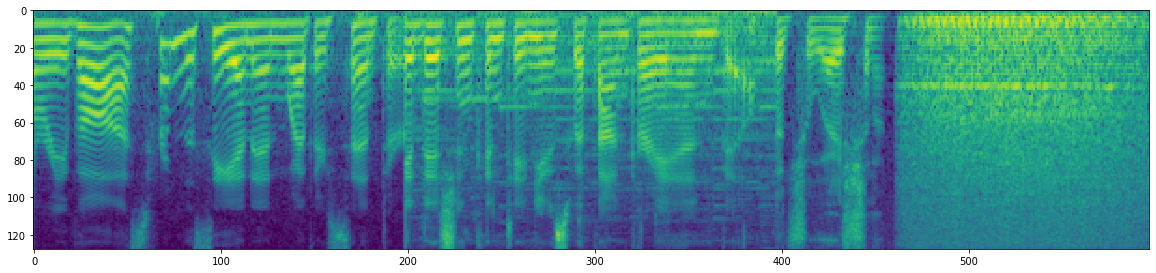

In [3]:
triplets = pd.read_csv('trainfiles/train-triplets.csv')
#triplets = triplets[triplets['anchor_speaker'] == 'i960711p_anchor2']
idx = np.random.randint(0, len(triplets))
triplet = triplets.iloc[idx]
anchor_segment = np.load(triplet['anchor_file'])/(2**15)
positive_segment = np.load(triplet['positive_file'])/(2**15)
negative_segment = np.load(triplet['negative_file'])/(2**15)
print(triplet)
print(anchor_segment.std())

S = librosa.feature.melspectrogram(np.concatenate((anchor_segment, positive_segment, negative_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
ipd.Audio(np.concatenate((anchor_segment, positive_segment, negative_segment)), rate = sr)

peter_jennings j960524c_f_us_012
(128, 398)
different


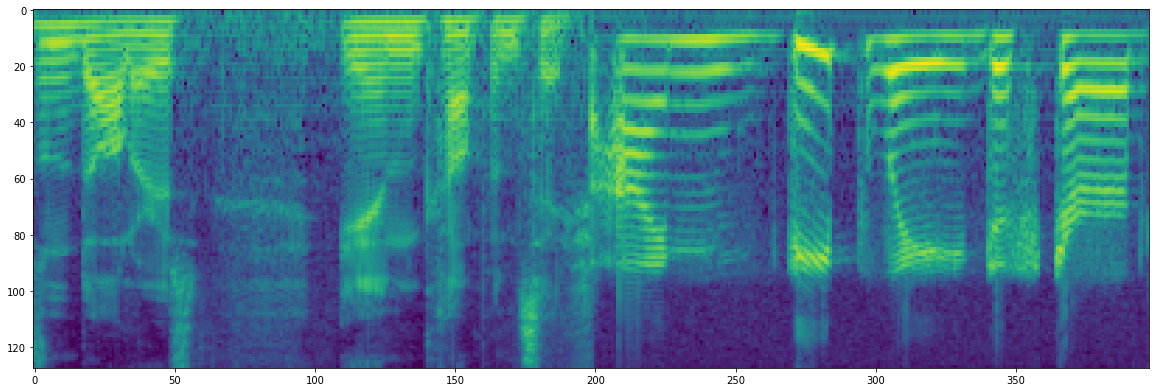

In [4]:
pairs = pd.read_csv('trainfiles/train-pairs.csv')
idx = np.random.randint(0, len(pairs))
pair = pairs.iloc[idx]
print(pair['first_speaker'], pair['second_speaker'])
first_segment = np.load(pair['first_file'])/(2**15)
second_segment = np.load(pair['second_file'])/(2**15)
S = librosa.feature.melspectrogram(np.concatenate((first_segment, second_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
if pair['label']:
    print('different')
else:
    print('same')
ipd.Audio(np.concatenate((first_segment, second_segment)), rate = sr)


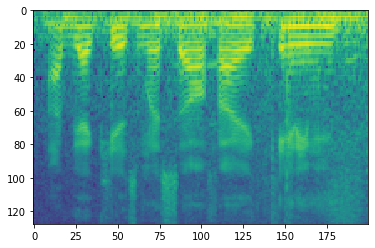

In [5]:
class TripletsDataSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.triplets = pd.read_csv(csv)
    def __len__(self):
        return len(self.triplets)
    def __getitem__(self, idx):
        triplet = self.triplets.iloc[idx]
        anchor_segment = np.load(triplet['anchor_file'])/(2**15)
        positive_segment = np.load(triplet['positive_file'])/(2**15)
        negative_segment = np.load(triplet['negative_file'])/(2**15)
        return self.make_spectrogram(anchor_segment), self.make_spectrogram(positive_segment), self.make_spectrogram(negative_segment)
    def make_spectrogram(self, segment):
        segment = segment[50:-50] # make size 200
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 160) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S).T[None, :, :] # add channel dimension
        return(S_dB)
trainset = TripletsDataSet('trainfiles/train-triplets.csv')

class PairSet(torch.utils.data.Dataset):
    def __init__(self, csv):
        super().__init__()
        self.pairs = pd.read_csv(csv)
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        pair = self.pairs.iloc[idx]
        seg1 = np.load(pair['first_file'])/(2**15)
        seg2 = np.load(pair['second_file'])/(2**15)
        seg1, seg2 = self.make_spectrogram(seg1), self.make_spectrogram(seg2)
        label = pair['label']
        return (seg1, seg2), label
    def make_spectrogram(self, segment):
        segment = segment[50:-50] # make size 200
        S = librosa.feature.melspectrogram(segment, n_mels = 128, n_fft = 512, hop_length = 160) # 32 ms window, 10 ms hop
        S_dB = librosa.power_to_db(S).T[None, :, :] # add channel dimension
        return(S_dB)
trainset_cls = PairSet('trainfiles/train-pairs.csv')
valset = PairSet('trainfiles/val-pairs.csv')
testset = PairSet('testfiles/test-pairs.csv')
idx = np.random.randint(len(valset))
plt.imshow(valset[idx][0][np.random.randint(2)][0].T)

## Causal version, slow, maybe try torch jit

In [6]:
class Spectral_Attention(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Spectral_Attention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first = False)
        self.attention = nn.Linear(hidden_size*num_layers, input_size) # can replace this with better attention mechanism
    def zero_state(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda(device))
    def forward(self, X, prev_state = None, mask = None): # X: (sequence length, batch, hidden size)
        batch_size = X.shape[1]
        if prev_state == None: # if we don't initialize hidden state
            prev_state = self.zero_state(batch_size)
        if mask == None:
            mask = torch.ones(batch_size, self.input_size).cuda(device)
        outputs = []
        for t, x in enumerate(X):
            x = x*mask
            x = x[None, ...] # 1, batch, hidden_size
            output, (state_h, state_c) = self.cell(x, prev_state)
            prev_state = (state_h, state_c)
            state_h = state_h.view(batch_size, -1)
            mask = self.attention(state_h)
            outputs.append(output)
        outputs = torch.cat(outputs, dim = 0)
        return outputs

## Noncausal version with Residual Attention
## I think the reason for that is that microphones cause noise which leads to masking and only placing attention on actual formants helps with that

In [8]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np

class ResidualBlock(nn.Module):
    def __init__(self, input_channels, output_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.stride = stride
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(input_channels, output_channels, 1, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(output_channels, output_channels, 3, stride, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(output_channels, output_channels, 1, 1, bias = False)
        self.conv4 = nn.Conv2d(input_channels, output_channels , 1, stride, bias = False)
        
    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out1 = self.relu(out)
        out = self.conv1(out1)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)
        if (self.input_channels != self.output_channels) or (self.stride !=1 ):
            residual = self.conv4(out1)
        out += residual
        return out

class AttentionModule_stage1(nn.Module):
    # input size is 56*56
    def __init__(self, in_channels, out_channels, size1=(200, 64), size2=(100, 32), size3=(50, 16)):
        super(AttentionModule_stage1, self).__init__()
        self.first_residual_blocks = ResidualBlock(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
         )

        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax1_blocks = ResidualBlock(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax2_blocks = ResidualBlock(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock(in_channels, out_channels)

        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.softmax3_blocks = nn.Sequential(
            ResidualBlock(in_channels, out_channels),
            ResidualBlock(in_channels, out_channels)
        )

        self.interpolation3 = nn.UpsamplingBilinear2d(size=size3)

        self.softmax4_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation2 = nn.UpsamplingBilinear2d(size=size2)

        self.softmax5_blocks = ResidualBlock(in_channels, out_channels)

        self.interpolation1 = nn.UpsamplingBilinear2d(size=size1)

        self.softmax6_blocks = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels , kernel_size = 1, stride = 1, bias = False),
            nn.Sigmoid()
        )

        self.last_blocks = ResidualBlock(in_channels, out_channels)

    def forward(self, x):
        #batch_size, nheads, length, n_mels = x.shape
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        out_mpool1 = self.mpool1(x) # 100x64
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1) # 50x32
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2) # 25x16
        out_softmax3 = self.softmax3_blocks(out_mpool3) 
        out_interp3 = self.interpolation3(out_softmax3) + out_softmax2
        out = out_interp3 + out_skip2_connection
        out_softmax4 = self.softmax4_blocks(out)
        out_interp2 = self.interpolation2(out_softmax4) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp1 = self.interpolation1(out_softmax5) + out_trunk
        out_softmax6 = self.softmax6_blocks(out_interp1)
        out = (1 + out_softmax6) * out_trunk
        out_last = self.last_blocks(out)
        return out_last

num_heads = 4 # Residual Attention Channels
num_heads_2 = 4 # MHA heads


class Siamese(nn.Module):
    def __init__(self):
        super().__init__()
        self.ln = nn.BatchNorm2d(1)
        self.downsample1 = ResidualBlock(1, num_heads, (1, 2))
        self.res_att = AttentionModule_stage1(num_heads, num_heads)  # batch_size * num_heads * L *128
        self.downsample2 = ResidualBlock(num_heads, num_heads//2, (1, 2))
        self.reshape =  Lambda(lambda x: x.permute((2, 0, 1, 3)).contiguous().view(x.shape[2], x.shape[0], -1)) # L * batch_size * (num_heads*128)
        self.lstm = nn.LSTM(64, 32, 2, batch_first = False, bidirectional = True, dropout = dropout) # L * batch_size * 200 * n_hidden
        self.mha =  torch.nn.MultiheadAttention(64, num_heads = num_heads_2, dropout=dropout, bias=True, kdim=64, vdim=64) # L * N * 64
        self.fc = nn.Linear(64, 32)
        self.average = Lambda(lambda x: x.mean(dim = 0)) # batch * n_hidden
        self.norm = Lambda(lambda x: torch.nn.functional.normalize(x, p = 2, dim = 1)) # L2 normalize across n_hidden
    def forward(self, X):
        X = self.ln(X)
        X = self.downsample1(X)
        #print('first downsample ', X.shape)
        X = self.res_att(X)
        #print('residual attention ', X.shape)
        X = self.downsample2(X)
        #print('second downsample ', X.shape)
        X = self.reshape(X)
        #print('reshape ', X.shape)
        X,_ = self.lstm(X)
        #print('lstm ', X.shape)
        X,_ = self.mha(X, X, X)
        #print('mha ', X.shape)
        X = self.fc(X)
        #print('dense ', X.shape)
        X = self.average(X)
        #print('mean ', X.shape)
        X = self.norm(X)
        #print('norm ', X.shape)
        return X
    
    
siamese = Siamese().cuda(device)
    
# tune hidden layers smaller if overfit
optimizer = torch.optim.Adam(siamese.parameters(), 0.001)

if os.path.exists('models/siamese.pth'):
    print('load model')
    checkpoint = torch.load('models/siamese.pth')
    siamese.load_state_dict(checkpoint['model_state_dict'])
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except:
        print('cannot load optimizer')
    loss = checkpoint['loss']
else:
    print('initializing new model')

if half:
    siamese.half()  # convert to half precision
    for layer in siamese.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.float()
            
siamese.train()
pass

initializing new model


## Things to try: Maybe add a multi-headed timewise attention to LSTM output? See if it focuses on attack of sounds? Actually, I can pretrain using tanh+averaging, then during classification, apply tanh+concat+MHA

## Pre-train embedding

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 0.3):
        super(TripletLoss, self).__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative, size_average=True):
        # anchor - positive shape is batch_size * n_embedding
        distance_positive = (anchor - positive).pow(2).sum(1).pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1).pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, pin_memory = True, num_workers = 8)
criterion = TripletLoss()
lasttime = time.time()


for epoch in range(10):
    running_loss = 0.0
    for batch_idx, (X_anchor, X_pos, X_neg) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        if half:
            X_anchor, X_pos, X_neg = X_anchor.half(), X_pos.half(), X_neg.half()
        X_anchor, X_pos, X_neg = X_anchor.cuda(device), X_pos.cuda(device), X_neg.cuda(device)
        out_anchor, out_pos, out_neg = siamese(X_anchor), siamese(X_pos), siamese(X_neg)
        loss = criterion(out_anchor, out_pos, out_neg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(siamese.parameters(), 0.5)
        optimizer.step()



        running_loss += loss.item()
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_idx + 1, running_loss / 200))
            running_loss = 0.0
            torch.save({
            'model_state_dict': siamese.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'models/siamese.pth')
        #measure time
        #print('batch time: ', str(time.time()-lasttime)[:4])
        lasttime = time.time()


[1,   200] loss: 0.116
[1,   400] loss: 0.091
[1,   600] loss: 0.077
[1,   800] loss: 0.051
[1,  1000] loss: 0.064
[1,  1200] loss: 0.049
[1,  1400] loss: 0.043
[1,  1600] loss: 0.031
[1,  1800] loss: 0.040
[1,  2000] loss: 0.042
[1,  2200] loss: 0.055
[1,  2400] loss: 0.050
[1,  2600] loss: 0.018
[1,  2800] loss: 0.030
[1,  3000] loss: 0.043
[1,  3200] loss: 0.023
[1,  3400] loss: 0.023
[1,  3600] loss: 0.034
[1,  3800] loss: 0.027
[1,  4000] loss: 0.075
[1,  4200] loss: 0.017
[1,  4400] loss: 0.021
[1,  4600] loss: 0.065
[1,  4800] loss: 0.034
[1,  5000] loss: 0.030
[1,  5200] loss: 0.019
[1,  5400] loss: 0.029
[1,  5600] loss: 0.024
[1,  5800] loss: 0.034
[1,  6000] loss: 0.030
[1,  6200] loss: 0.081
[1,  6400] loss: 0.049
[1,  6600] loss: 0.038
[1,  6800] loss: 0.026
[1,  7000] loss: 0.040
[1,  7200] loss: 0.027
[1,  7400] loss: 0.037
[1,  7600] loss: 0.022
[1,  7800] loss: 0.020
[1,  8000] loss: 0.025
[1,  8200] loss: 0.018
[1,  8400] loss: 0.010
[1,  8600] loss: 0.027
[1,  8800] 

[2,   200] loss: 0.019
[2,   400] loss: 0.010
[2,   600] loss: 0.012
[2,   800] loss: 0.020
[2,  1000] loss: 0.012
[2,  1200] loss: 0.019
[2,  1400] loss: 0.034
[2,  1600] loss: 0.028
[2,  1800] loss: 0.015
[2,  2000] loss: 0.035
[2,  2200] loss: 0.055
[2,  2400] loss: 0.017
[2,  2600] loss: 0.020
[2,  2800] loss: 0.017
[2,  3000] loss: 0.005
[2,  3200] loss: 0.018
[2,  3400] loss: 0.018
[2,  3600] loss: 0.010
[2,  3800] loss: 0.010
[2,  4000] loss: 0.011
[2,  4200] loss: 0.011
[2,  4400] loss: 0.018
[2,  4600] loss: 0.008
[2,  4800] loss: 0.008
[2,  5000] loss: 0.013
[2,  5200] loss: 0.012
[2,  5400] loss: 0.055
[2,  5600] loss: 0.023
[2,  5800] loss: 0.017
[2,  6000] loss: 0.004
[2,  6200] loss: 0.010
[2,  6400] loss: 0.013
[2,  6600] loss: 0.003
[2,  6800] loss: 0.006
[2,  7000] loss: 0.004
[2,  7200] loss: 0.002
[2,  7400] loss: 0.014
[2,  7600] loss: 0.005
[2,  7800] loss: 0.014
[2,  8000] loss: 0.016
[2,  8200] loss: 0.013
[2,  8400] loss: 0.008
[2,  8600] loss: 0.024
[2,  8800] 

[3,   200] loss: 0.008
[3,   400] loss: 0.010
[3,   600] loss: 0.020
[3,   800] loss: 0.009
[3,  1000] loss: 0.003
[3,  1200] loss: 0.011
[3,  1400] loss: 0.008
[3,  1600] loss: 0.003
[3,  1800] loss: 0.007
[3,  2000] loss: 0.009
[3,  2200] loss: 0.008
[3,  2400] loss: 0.008
[3,  2600] loss: 0.008
[3,  2800] loss: 0.019
[3,  3000] loss: 0.009
[3,  3200] loss: 0.016
[3,  3400] loss: 0.010
[3,  3600] loss: 0.004
[3,  3800] loss: 0.017
[3,  4000] loss: 0.017
[3,  4200] loss: 0.011
[3,  4400] loss: 0.013
[3,  4600] loss: 0.017
[3,  4800] loss: 0.007
[3,  5000] loss: 0.011
[3,  5200] loss: 0.024
[3,  5400] loss: 0.003
[3,  5600] loss: 0.003
[3,  5800] loss: 0.023
[3,  6000] loss: 0.009
[3,  6200] loss: 0.019
[3,  6400] loss: 0.012
[3,  6600] loss: 0.024
[3,  6800] loss: 0.004
[3,  7000] loss: 0.018
[3,  7200] loss: 0.001
[3,  7400] loss: 0.000
[3,  7600] loss: 0.012
[3,  7800] loss: 0.000
[3,  8000] loss: 0.004
[3,  8200] loss: 0.002
[3,  8400] loss: 0.007
[3,  8600] loss: 0.013
[3,  8800] 

[4,   200] loss: 0.013
[4,   400] loss: 0.011
[4,   600] loss: 0.007
[4,   800] loss: 0.008
[4,  1000] loss: 0.005
[4,  1200] loss: 0.005
[4,  1400] loss: 0.007
[4,  1600] loss: 0.020
[4,  1800] loss: 0.002
[4,  2000] loss: 0.004
[4,  2200] loss: 0.006
[4,  2400] loss: 0.012
[4,  2600] loss: 0.004
[4,  2800] loss: 0.011
[4,  3000] loss: 0.003
[4,  3200] loss: 0.007
[4,  3400] loss: 0.001
[4,  3600] loss: 0.010
[4,  3800] loss: 0.007
[4,  4000] loss: 0.007
[4,  4200] loss: 0.003
[4,  4400] loss: 0.003
[4,  4600] loss: 0.012
[4,  4800] loss: 0.018
[4,  5000] loss: 0.012
[4,  5200] loss: 0.012
[4,  5400] loss: 0.003
[4,  5600] loss: 0.000
[4,  5800] loss: 0.010
[4,  6000] loss: 0.005
[4,  6200] loss: 0.005
[4,  6400] loss: 0.001
[4,  6600] loss: 0.004
[4,  6800] loss: 0.007
[4,  7000] loss: 0.005
[4,  7200] loss: 0.004
[4,  7400] loss: 0.013
[4,  7600] loss: 0.009
[4,  7800] loss: 0.011
[4,  8000] loss: 0.003
[4,  8200] loss: 0.005
[4,  8400] loss: 0.010
[4,  8600] loss: 0.008
[4,  8800] 

[5,   200] loss: 0.007
[5,   400] loss: 0.013
[5,   600] loss: 0.006
[5,   800] loss: 0.003
[5,  1000] loss: 0.010
[5,  1200] loss: 0.001
[5,  1400] loss: 0.004
[5,  1600] loss: 0.006
[5,  1800] loss: 0.011
[5,  2000] loss: 0.023
[5,  2200] loss: 0.013
[5,  2400] loss: 0.006
[5,  2600] loss: 0.012
[5,  2800] loss: 0.010
[5,  3000] loss: 0.003
[5,  3200] loss: 0.012
[5,  3400] loss: 0.004
[5,  3600] loss: 0.002
[5,  3800] loss: 0.017
[5,  4000] loss: 0.005
[5,  4200] loss: 0.001
[5,  4400] loss: 0.000
[5,  4600] loss: 0.003
[5,  4800] loss: 0.017
[5,  5000] loss: 0.008
[5,  5200] loss: 0.006
[5,  5400] loss: 0.006
[5,  5600] loss: 0.006
[5,  5800] loss: 0.009
[5,  6000] loss: 0.003
[5,  6200] loss: 0.002
[5,  6400] loss: 0.016
[5,  6600] loss: 0.005
[5,  6800] loss: 0.005
[5,  7000] loss: 0.000
[5,  7200] loss: 0.002
[5,  7400] loss: 0.007
[5,  7600] loss: 0.001
[5,  7800] loss: 0.004
[5,  8000] loss: 0.002
[5,  8200] loss: 0.010
[5,  8400] loss: 0.007
[5,  8600] loss: 0.010
[5,  8800] 

[6,   200] loss: 0.003
[6,   400] loss: 0.009
[6,   600] loss: 0.001
[6,   800] loss: 0.005
[6,  1000] loss: 0.004
[6,  1200] loss: 0.006
[6,  1400] loss: 0.002
[6,  1600] loss: 0.009
[6,  1800] loss: 0.009
[6,  2000] loss: 0.016
[6,  2200] loss: 0.002
[6,  2400] loss: 0.006
[6,  2600] loss: 0.006
[6,  2800] loss: 0.004
[6,  3000] loss: 0.000
[6,  3200] loss: 0.006
[6,  3400] loss: 0.000
[6,  3600] loss: 0.004
[6,  3800] loss: 0.015
[6,  4000] loss: 0.005
[6,  4200] loss: 0.007
[6,  4400] loss: 0.001
[6,  4600] loss: 0.005
[6,  4800] loss: 0.003
[6,  5000] loss: 0.009
[6,  5200] loss: 0.006
[6,  5400] loss: 0.004
[6,  5600] loss: 0.010
[6,  5800] loss: 0.010
[6,  6000] loss: 0.002
[6,  6200] loss: 0.003
[6,  6400] loss: 0.014
[6,  6600] loss: 0.006
[6,  6800] loss: 0.009
[6,  7000] loss: 0.007
[6,  7200] loss: 0.010
[6,  7400] loss: 0.017
[6,  7600] loss: 0.007
[6,  7800] loss: 0.002
[6,  8000] loss: 0.001
[6,  8200] loss: 0.001
[6,  8400] loss: 0.003
[6,  8600] loss: 0.008
[6,  8800] 

[7,   200] loss: 0.011
[7,   400] loss: 0.006
[7,   600] loss: 0.002
[7,   800] loss: 0.007
[7,  1000] loss: 0.009
[7,  1200] loss: 0.002
[7,  1400] loss: 0.000
[7,  1600] loss: 0.005
[7,  1800] loss: 0.001
[7,  2000] loss: 0.002
[7,  2200] loss: 0.005
[7,  2400] loss: 0.002
[7,  2600] loss: 0.002
[7,  2800] loss: 0.005
[7,  3000] loss: 0.007
[7,  3200] loss: 0.001
[7,  3400] loss: 0.004
[7,  3600] loss: 0.006
[7,  3800] loss: 0.002
[7,  4000] loss: 0.006
[7,  4200] loss: 0.000
[7,  4400] loss: 0.006
[7,  4600] loss: 0.001
[7,  4800] loss: 0.018
[7,  5000] loss: 0.009
[7,  5200] loss: 0.005
[7,  5400] loss: 0.003
[7,  5600] loss: 0.001
[7,  5800] loss: 0.010
[7,  6000] loss: 0.002
[7,  6200] loss: 0.003
[7,  6400] loss: 0.003
[7,  6600] loss: 0.007
[7,  6800] loss: 0.002
[7,  7000] loss: 0.005
[7,  7200] loss: 0.003
[7,  7400] loss: 0.007
[7,  7600] loss: 0.008
[7,  7800] loss: 0.006
[7,  8000] loss: 0.001
[7,  8200] loss: 0.003
[7,  8400] loss: 0.002
[7,  8600] loss: 0.005
[7,  8800] 

[8,   200] loss: 0.002
[8,   400] loss: 0.004
[8,   600] loss: 0.002
[8,   800] loss: 0.006
[8,  1000] loss: 0.006
[8,  1200] loss: 0.010
[8,  1400] loss: 0.002
[8,  1600] loss: 0.002
[8,  1800] loss: 0.016
[8,  2000] loss: 0.018
[8,  2200] loss: 0.004
[8,  2400] loss: 0.000
[8,  2600] loss: 0.017
[8,  2800] loss: 0.002
[8,  3000] loss: 0.004
[8,  3200] loss: 0.017
[8,  3400] loss: 0.005
[8,  3600] loss: 0.003
[8,  3800] loss: 0.006
[8,  4000] loss: 0.002
[8,  4200] loss: 0.000
[8,  4400] loss: 0.018
[8,  4600] loss: 0.005
[8,  4800] loss: 0.005
[8,  5000] loss: 0.000
[8,  5200] loss: 0.002
[8,  5400] loss: 0.002
[8,  5600] loss: 0.003
[8,  5800] loss: 0.011
[8,  6000] loss: 0.004
[8,  6200] loss: 0.005
[8,  6400] loss: 0.007
[8,  6600] loss: 0.009
[8,  6800] loss: 0.005
[8,  7000] loss: 0.003
[8,  7200] loss: 0.003
[8,  7400] loss: 0.011
[8,  7600] loss: 0.011
[8,  7800] loss: 0.005
[8,  8000] loss: 0.000
[8,  8200] loss: 0.001
[8,  8400] loss: 0.002
[8,  8600] loss: 0.003
[8,  8800] 

[9,   200] loss: 0.005
[9,   400] loss: 0.000
[9,   600] loss: 0.005
[9,   800] loss: 0.002
[9,  1000] loss: 0.003
[9,  1200] loss: 0.002
[9,  1400] loss: 0.002
[9,  1600] loss: 0.006
[9,  1800] loss: 0.001
[9,  2000] loss: 0.003
[9,  2200] loss: 0.022


## Train Classifier ##

In [ ]:
class Classifier(nn.Module):
    def __init__(self, siamese):
        super().__init__()
        self.siamese = siamese
        self.fc1 = nn.Sequential(nn.Dropout(0), nn.Linear(64, 64), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Dropout(0), nn.Linear(64, 64), nn.ReLU())
        self.out = nn.Sequential(nn.Dropout(0), nn.Linear(64, 1)) # sigmoid is in loss
    def forward(self, x1, x2):
        embedding_1 = self.siamese(x1) # batch_size * n_embedding
        embedding_2 = self.siamese(x2) # batch_size * n_embedding
        x = torch.cat([embedding_1, embedding_2], dim = 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.out(x).view(x1.shape[0])

cls = Classifier(siamese).cuda(device)
optimizer_cls = torch.optim.Adam(cls.parameters(), 0.001)

if os.path.exists('models/cls.pth'):
    print('load model')
    checkpoint = torch.load('models/cls.pth')
    cls.load_state_dict(checkpoint['model_state_dict'])
    optimizer_cls.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    if 'bestacc' in checkpoint:
        bestacc = checkpoint['bestacc']
    else:
        bestacc = 0.0
else:
    print('initializing new model')
    bestacc = 0.0

if half:
    cls.half()  # convert to half precision
    for layer in cls.modules():
        if isinstance(layer, nn.BatchNorm2d):
            cls.float()
cls.train()
bestacc


In [ ]:
batch_size = 128
trainloader_cls = torch.utils.data.DataLoader(trainset_cls, batch_size=batch_size, shuffle=True, pin_memory = True, num_workers = 16)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
criterion = nn.BCEWithLogitsLoss()
lasttime = time.time()
cls.train()

for epoch in range(0, 32):
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_idx, ((X_1, X_2), label) in enumerate(tqdm(trainloader_cls)):
        optimizer_cls.zero_grad()
        if half:
            X_1, X_2 = X_1.half(), X_2.half()
        X_1, X_2, label = X_1.cuda(device), X_2.cuda(device), label.cuda(device)
        out = cls(X_1, X_2)
        label = label.float()
        loss = criterion(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cls.parameters(), 0.5)
        optimizer_cls.step()

        running_loss += loss.item()
        running_accuracy += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())/batch_size
        if batch_idx % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f accuracy: %.3f' % 
                  (epoch + 1, batch_idx + 1, running_loss / 200, running_accuracy / 200))
            running_loss = 0.0
            running_accuracy = 0.0
            torch.save({
            'model_state_dict': cls.state_dict(),
            'optimizer_state_dict': optimizer_cls.state_dict(),
            'loss': loss
            }, 'models/cls.pth')
    
    
    
    corrects = 0
    for batch_idx, ((X_1, X_2), label) in enumerate(tqdm(valloader)):
        if half:
            X_1, X_2 = X_1.half(), X_2.half()
        else:
            X_1, X_2 = X_1.float(), X_2.float()
        X_1, X_2, label = X_1.cuda(device), X_2.cuda(device), label.cuda(device)
        cls.eval()
        out = cls(X_1, X_2)
        label = label.float()
        corrects += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())
    print('val acc:', corrects/len(valset))
    if corrects/len(valset) > bestacc:
        bestacc = corrects/len(valset)
        torch.save({
        'model_state_dict': cls.state_dict(),
        'optimizer_state_dict': optimizer_cls.state_dict(),
        'loss': loss,
        'bestacc': bestacc
        }, 'models/best-cls.pth')
    cls.train()
            

# Test on separate file

(128, 200)

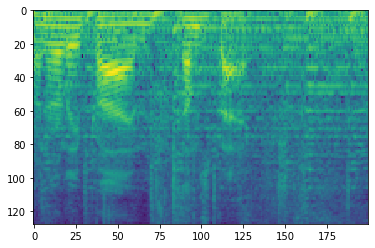

In [10]:
idx = np.random.randint(len(testset))
plt.imshow(testset[idx][0][np.random.randint(2)][0].T)
testset[idx][0][np.random.randint(2)][0].T.shape

In [12]:
checkpoint = torch.load('models/best-cls.pth')
cls.load_state_dict(checkpoint['model_state_dict'])

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, pin_memory = True, num_workers = 16)
cls.eval()

corrects = 0
for batch_idx, ((X_1, X_2), label) in enumerate(tqdm(testloader)):
    if half:
        X_1, X_2 = X_1.half(), X_2.half()
    else:
        X_1, X_2 = X_1.float(), X_2.float()
    X_1, X_2, label = X_1.cuda(device), X_2.cuda(device), label.cuda(device)
    out = cls(X_1, X_2)
    label = label.float()
    corrects += sum((out.data.cpu().numpy()>0) == label.data.cpu().numpy())
print('test acc:', corrects/len(testset))

cls.train()
pass


test acc: 0.8830721003134796


In [53]:
modulelist2 = list([cls.siamese.downsample1, cls.siamese.res_att, cls.siamese.downsample2])
modulelist1 = list([cls.siamese.downsample1, cls.siamese.res_att])
modulelist0 = list([cls.siamese.downsample1])
extractor2 = nn.Sequential(*modulelist2)
extractor1 = nn.Sequential(*modulelist1)
extractor0 = nn.Sequential(*modulelist0)

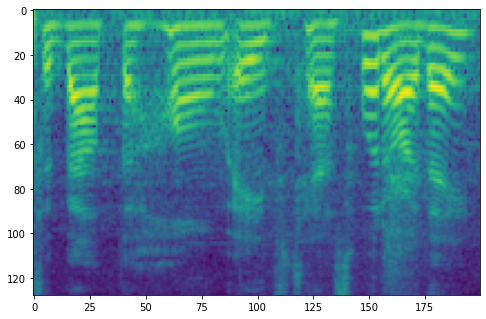

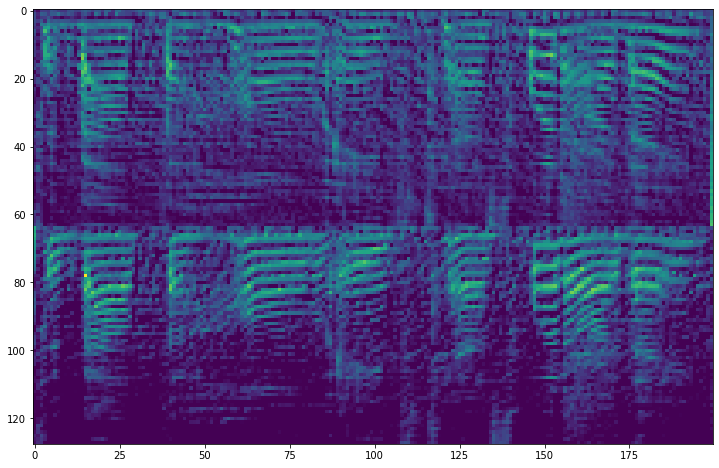

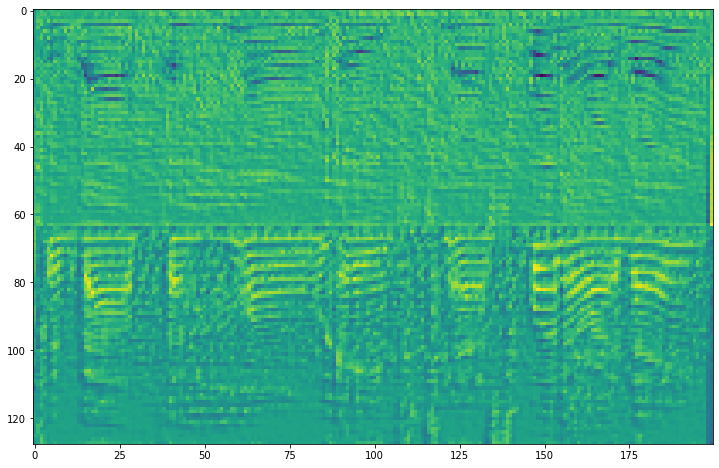

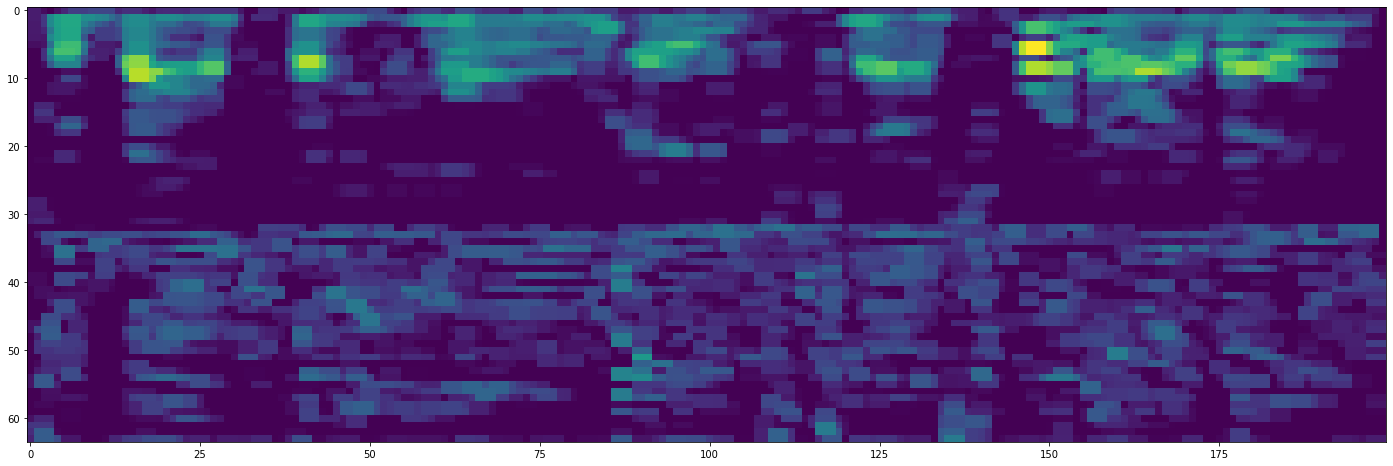

In [59]:
idx = np.random.randint(len(X_1))
out0 = extractor0(X_1[idx:idx+1])[0].detach().cpu().numpy()
out1 = extractor1(X_1[idx:idx+1])[0].detach().cpu().numpy()
out2 = extractor2(X_1[idx:idx+1])[0].detach().cpu().numpy()

#out = out.reshape(-1, out.shape[-1])
out0 = np.concatenate(out0, axis = 1)
out1 = np.concatenate(out1, axis = 1)
out2 = np.concatenate(out2, axis = 1)

plt.figure(figsize = (8, 8))
plt.imshow(X_1[idx][0].detach().cpu().numpy().T)
plt.figure(figsize = (32, 8))
plt.imshow(out0.T)
plt.figure(figsize = (32, 8))
plt.imshow(out1.T)
plt.figure(figsize = (32, 8))
plt.imshow(out2.T)

## Use both TDP and IFP